Introduction
Language Identification (LID) systems from voice are classification models that predict the spoken language from a given audio recording. The LID systems can facilitate the process of any speech processing system such as speech recognition (ASR) or speech translation systems. In speech-based assistant systems, LID works as a first step by selecting the appropriate grammar from a list of available languages for further semantic analysis. Also, these models can be employed in call centers in order to redirect an international user to an operator who is fluent in that identified language.

Objective
The objective of this project is to use machine learning methods for constructing a LID model which can discriminate 4 languages; English, French, Arabic, Japanese. There are 2 expected phases. The first phase is constructing a classifier. It is expected to compare the performance of different models, optimize the hyperparameters, and practice of finding the best model. The second phase is the evaluation of the model in a simulated situation of real life deployment. The objective is to understand the challenge of generalization. It's also expected to analyze the result of the model’s performance and make hypothesis about the weak and strong aspect of models. The competition among models' accuracy can provide a better understanding of performance

Data
The provided dataset has been collected from TEDx talks YouTube for the Language Identification task from audio. The samples are recorded audio of speaker speech from available TEDx talks videos. In order to have a standard sample's type, they follow below convention. The length of recorded audio files should be around 5 seconds (5.00 - 5.99 seconds). The format of audio files should be *.wav. The sample rate of recording files should be 16 kHz (in mono format).

Dataset
A repository contains recording files in the standard format (.wav, 16kHz, mono, 5-6 seconds) and a .txt file with 4 information (separated by , ) for each recorded file (one file per line) has been provided. The 1st column is the name of *.wav file The 2nd column is the URL address of YouTube video The 3rd column is the starting time of recording from YouTube video The 4th column is the label (language) of recorded speech (EN, FR, AR, JP)

Evaluation set
A repository contains recording files in the standard format (.wav, 16kHz, mono, 5-6 seconds) and a .txt file with 2 columns as the file names and a the predicted label by your classification model.

In [2]:
pip install --upgrade librosa

     -------------------------------------- 253.0/253.0 kB 5.3 MB/s eta 0:00:00
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl (1.0 MB)
  Using cached audioread-3.0.0.tar.gz (377 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached soxr-0.3.4-cp39-cp39-win_amd64.whl (184 kB)
  Using cached numpy-1.21.6-cp39-cp39-win_amd64.whl (14.0 MB)
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23736 sha256=be0c78596b3a440c053fd2ddc52bb1ab3402856a55bab8c78a50a1e5f86c06b5
  Stored in directory: c:\users\natha\appdata\local\pip\cache\wheels\7a\6a\b0\92760a6d6bc2bff5464970af910c0b0b921390993f3199cdf7
Successfully built audioread
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
Note: you may need to restart the kernel to use updated packages.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
cvae 0.0.3 requires tensorflow<2,>=1, but you have tensorflow 2.11.0 which is incompatible.


In [4]:
pip install catboost

  Using cached catboost-1.1.1-cp39-none-win_amd64.whl (74.0 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt 
import random
import csv
import os

import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

from catboost import CatBoostClassifier, Pool, cv

In [6]:
path_to_repo = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
path_to_repo

'C:\\Users\\Natha\\emlyon-dsaib\\Python tutorship\\Projet'

# Feature extractor

In [7]:
# sr should be set to your recording sample rate (16k)
# x,freq = librosa.load("[your_wav_files_directory]/FR_01.wav",sr=16000)
x,freq = librosa.load('C:\\Users\\Natha\\emlyon-dsaib\\Python tutorship\\Projet\\language-identification-lid2\\dataset\\partition7\\0000.wav',sr=16000)
# The load function will return a time series value (x) and
#   the input sample rate (freq) which is 16000
print("The duration of FR_001.wav in seconds:",len(x)/freq)

The duration of FR_001.wav in seconds: 5.494


In [8]:
# This function will return n_mfcc number of MFCC per
#     a window of time in audio time series
x_mfcc=librosa.feature.mfcc(y=x,sr=freq, n_mfcc=40)
print(x_mfcc.shape)
# x_mfcc is an array with 40 values for a window of time
# The len(x_mfcc) is a proportion of wav file duration (5-6 seconds)

(40, 172)


### Method 1: Computing statistics from time series:¶

By computing mean, variance, median, etc. it is possible to summarize and convert a list of values with variable length to one (or certain number of) value. In this method, the information related to the time will be lost.

In [9]:
def feature_extractor_1(audio_file_dir):

    #load the audio files
    x,freq = librosa.load(audio_file_dir,sr=16000)
    #extract 20 MFCCs
    mfcc=librosa.feature.mfcc(y=x,sr=freq,n_mfcc=20)
    #calculate the mean and variance of each MFFC 
    mean_mfccs=np.mean(mfcc,axis=1)
    var_mfccs=np.var(mfcc,axis=1)
    #return mean and variance as the audio file feature 
    return list(mean_mfccs)+list(var_mfccs)

### Method 2 : Converting sample to a fixed length:

The audio time series data can be cut to a fix length (such as minimum length of 5.00 seconds) which called \textit{Sequence Truncation}. Another method to have a fix length sequence is padding to a maximum length (for example 6.00 seconds) by concatenating a constant value such as 0 to the end (or beginning) of the sequence. These two model will keep the information related to the time in the time series data.

In [10]:
def feature_extractor_2(audio_file_dir):

    #load the audio files
    x,freq = librosa.load(audio_file_dir,sr=16000)
    # trim the first 5 seconds (Sequence Truncation)
    length_of_5seconds=5*16000
    x_5sec=x[:length_of_5seconds]
    # extract 20 MFCCs
    mfccs_5sec=librosa.feature.mfcc(x_5sec,sr=freq,n_mfcc=20)
    # return mfcc of the first 5 sec as the audio file feature
    return mfccs_5sec

# Data

In [11]:
#set data_dir to the directory of your data files
data_dir= "C:\\Users\\Natha\\emlyon-dsaib\\Python tutorship\\Projet\\language-identification-lid2\\dataset\\partition7\\info.txt"

In [12]:
file_list=[]
label_list=[]


with open(data_dir, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        filename = parts[0]
        label = parts[-1]
        file_list.append(filename)
        label_list.append(label)

In [13]:
file_list

['0000.wav',
 '0001.wav',
 '0002.wav',
 '0003.wav',
 '0004.wav',
 '0005.wav',
 '0006.wav',
 '0007.wav',
 '0008.wav',
 '0009.wav',
 '0010.wav',
 '0011.wav',
 '0012.wav',
 '0013.wav',
 '0014.wav',
 '0015.wav',
 '0016.wav',
 '0017.wav',
 '0018.wav',
 '0019.wav',
 '0020.wav',
 '0021.wav',
 '0022.wav',
 '0023.wav',
 '0024.wav',
 '0025.wav',
 '0026.wav',
 '0027.wav',
 '0028.wav',
 '0029.wav',
 '0030.wav',
 '0031.wav',
 '0032.wav',
 '0033.wav',
 '0034.wav',
 '0035.wav',
 '0036.wav',
 '0037.wav',
 '0038.wav',
 '0039.wav',
 '0040.wav',
 '0041.wav',
 '0042.wav',
 '0043.wav',
 '0044.wav',
 '0045.wav',
 '0046.wav',
 '0047.wav',
 '0048.wav',
 '0049.wav',
 '0050.wav',
 '0051.wav',
 '0052.wav',
 '0053.wav',
 '0054.wav',
 '0055.wav',
 '0056.wav',
 '0057.wav',
 '0058.wav',
 '0059.wav',
 '0060.wav',
 '0061.wav',
 '0062.wav',
 '0063.wav',
 '0064.wav',
 '0065.wav',
 '0066.wav',
 '0067.wav',
 '0068.wav',
 '0069.wav',
 '0070.wav',
 '0071.wav',
 '0072.wav',
 '0073.wav',
 '0074.wav',
 '0075.wav',
 '0076.wav',

In [14]:
label_list

['EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',
 'EN',

In [15]:
# create a dictionary for labels
lang_dic={'EN':0,'FR':1,'AR':2,'JP':3}


In [16]:
#set data_dir to the directory of your data files
audio_dir= "C:\\Users\\Natha\\emlyon-dsaib\\Python tutorship\\Projet\\language-identification-lid2\\dataset\\partition7\\"

In [17]:
# create a list of extracted feature (MFCC) for files
x_data=[]

for filename in file_list:
    # Load audio file
    file_path = audio_dir + filename
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCC features and their mean and variance
    mfcc_mean_var = feature_extractor_1(file_path)
    
    # Append to x_data
    x_data.append(mfcc_mean_var)
    
    

In [18]:
x_data

[[-258.88367,
  67.37105,
  -28.78494,
  -5.78444,
  -19.87059,
  -2.3538218,
  -10.67521,
  -12.744838,
  -6.630191,
  -3.2747338,
  -6.5160875,
  6.572232,
  4.2581997,
  11.494615,
  -2.4039915,
  5.383331,
  -7.9236946,
  -1.8388846,
  -5.481099,
  0.72487205,
  16666.305,
  890.96747,
  855.3759,
  653.5658,
  549.659,
  315.43524,
  137.68758,
  128.12097,
  221.39354,
  142.46373,
  100.2743,
  87.089066,
  105.03227,
  75.24782,
  76.597374,
  117.79232,
  105.32758,
  85.171,
  124.0752,
  104.84019],
 [-203.60902,
  52.13864,
  -35.56175,
  1.7101476,
  -24.620663,
  -9.546795,
  -21.75146,
  -9.321721,
  -8.346843,
  -1.135831,
  -8.465665,
  7.1174154,
  -1.1411084,
  7.850812,
  -8.548041,
  3.3962543,
  -9.739369,
  -2.7142437,
  -2.464401,
  3.523078,
  9096.295,
  1270.6829,
  969.2335,
  506.04248,
  340.34854,
  224.76546,
  142.1585,
  114.59282,
  146.47855,
  117.07799,
  70.23044,
  75.36557,
  80.699135,
  89.4854,
  57.872932,
  48.15194,
  102.35979,
  128.2244

In [19]:
np.array(x_data)[1].shape

(40,)

In [20]:
# create a list of labels for files
y_data = []

for label in label_list:
    # Split label into its components
    label_parts = label.split(',')

    # Extract language label and convert to numerical value
    lang_label = label_parts[-1].strip()
    lang_code = lang_dic[lang_label]

    # Append to y_data
    y_data.append(lang_code)


In [21]:
y_data

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [22]:
# shuffle two lists
# Hint : make a list of zip (x_data, y_data) and then use random.shuffle 
# Create a list of tuples by zipping x_data and y_data together
data = list(zip(x_data, y_data))

# Shuffle the list of tuples
random.shuffle(data)

# Unzip the list of tuples to get back the two original lists in shuffled order
x_data, y_data = zip(*data)


# DF

In [23]:
type(data)

list

In [24]:
df = pd.DataFrame(x_data)

In [25]:
df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-248.128159,61.303684,-19.975313,19.798573,-4.117367,-4.895715,-17.358507,-11.942326,-0.887034,-13.839718,...,73.389374,76.826630,76.895599,87.658760,74.518936,63.381691,63.509331,88.355316,143.243225,224.491592
1,-227.963181,29.403967,-92.605980,25.436537,-13.943529,-11.942792,-23.799694,2.439936,-4.780290,-1.518001,...,159.218857,179.757599,128.857239,100.173042,123.832306,172.844879,147.451279,90.275749,157.819168,122.855034
2,-367.714355,84.768921,-14.442950,17.228878,-14.266505,-21.237408,-6.853325,-17.390331,-7.362807,-7.884434,...,73.392982,75.081322,88.733971,43.143719,53.145477,44.339607,41.940868,45.784637,58.414825,33.092609
3,-408.614471,65.062874,-3.461067,23.298765,-5.167718,-6.868882,-10.238270,-10.013874,-3.846821,-8.435979,...,105.423798,113.685074,205.002029,292.279968,314.066010,213.689926,331.186981,560.553467,452.160522,394.947571
4,-282.728638,133.492111,5.505677,-13.809141,6.786129,11.818027,-5.320152,-13.286053,-6.614403,1.260433,...,104.905647,82.350685,76.866112,82.891014,58.766121,54.383972,49.545364,71.772606,54.621117,37.779202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,-347.344604,76.998276,-7.739465,15.402439,0.422429,0.546733,-5.391399,-4.024202,-6.837125,-7.856150,...,61.145725,101.442505,40.355484,32.903236,46.642784,31.679495,36.315010,29.811001,32.518738,37.335407
585,-123.547653,82.733696,-16.028028,15.209191,-17.696552,-15.167856,-19.630817,-10.001487,-3.730552,-2.771024,...,86.325241,97.338722,80.465233,109.561638,50.503128,66.590225,144.432068,201.716476,156.727737,138.671890
586,-355.408539,113.639374,-8.238214,-6.050410,-25.043859,-32.435711,-2.681955,9.396270,-4.411253,9.460797,...,52.955227,42.968689,40.768856,35.323669,27.976421,36.866512,51.115898,61.877457,56.489166,78.596199
587,-310.173096,90.196533,-11.730412,34.159313,0.865455,19.629356,1.311089,14.075998,1.686203,5.130901,...,58.052486,43.503632,54.277916,86.208717,62.405777,56.055653,47.341019,50.427452,48.265728,57.144554


In [26]:
type(y_data)

tuple

In [27]:
labels = pd.Series(y_data)

In [28]:
df[40] = labels

In [29]:
df.rename(columns={ 40: 'Labels'}, inplace=True)

In [30]:
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Labels
0,-248.128159,61.303684,-19.975313,19.798573,-4.117367,-4.895715,-17.358507,-11.942326,-0.887034,-13.839718,...,76.826630,76.895599,87.658760,74.518936,63.381691,63.509331,88.355316,143.243225,224.491592,1
1,-227.963181,29.403967,-92.605980,25.436537,-13.943529,-11.942792,-23.799694,2.439936,-4.780290,-1.518001,...,179.757599,128.857239,100.173042,123.832306,172.844879,147.451279,90.275749,157.819168,122.855034,1
2,-367.714355,84.768921,-14.442950,17.228878,-14.266505,-21.237408,-6.853325,-17.390331,-7.362807,-7.884434,...,75.081322,88.733971,43.143719,53.145477,44.339607,41.940868,45.784637,58.414825,33.092609,2
3,-408.614471,65.062874,-3.461067,23.298765,-5.167718,-6.868882,-10.238270,-10.013874,-3.846821,-8.435979,...,113.685074,205.002029,292.279968,314.066010,213.689926,331.186981,560.553467,452.160522,394.947571,3
4,-282.728638,133.492111,5.505677,-13.809141,6.786129,11.818027,-5.320152,-13.286053,-6.614403,1.260433,...,82.350685,76.866112,82.891014,58.766121,54.383972,49.545364,71.772606,54.621117,37.779202,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,-347.344604,76.998276,-7.739465,15.402439,0.422429,0.546733,-5.391399,-4.024202,-6.837125,-7.856150,...,101.442505,40.355484,32.903236,46.642784,31.679495,36.315010,29.811001,32.518738,37.335407,2
585,-123.547653,82.733696,-16.028028,15.209191,-17.696552,-15.167856,-19.630817,-10.001487,-3.730552,-2.771024,...,97.338722,80.465233,109.561638,50.503128,66.590225,144.432068,201.716476,156.727737,138.671890,0
586,-355.408539,113.639374,-8.238214,-6.050410,-25.043859,-32.435711,-2.681955,9.396270,-4.411253,9.460797,...,42.968689,40.768856,35.323669,27.976421,36.866512,51.115898,61.877457,56.489166,78.596199,1
587,-310.173096,90.196533,-11.730412,34.159313,0.865455,19.629356,1.311089,14.075998,1.686203,5.130901,...,43.503632,54.277916,86.208717,62.405777,56.055653,47.341019,50.427452,48.265728,57.144554,0


In [31]:
df.isnull().sum()

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        0
35        0
36        0
37        0
38        0
39        0
Labels    0
dtype: int64

# Split Data

In [32]:
X = x_data
# y = target = the column we are learning to predict. 
y = y_data
print(np.array(X).shape,np.array(y).shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

(589, 40) (589,)


# RandomForest Classifier

In [33]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# Base Model

Accuracy:  0.7094594594594594


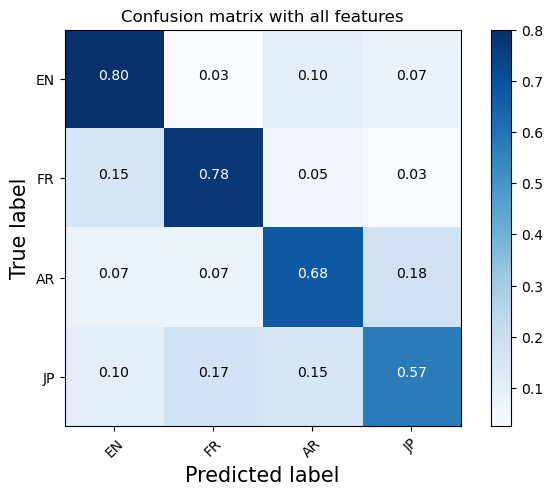

In [34]:
# Create a Random Forest classifier object
classifier = RandomForestClassifier()

# Train the classifier
classifier.fit(X_train, y_train)

#Make predictions
y_pred_class = classifier.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
# = roc_auc_score(y_test, y_pred_prob)
#print("ROC_AUC_Score: ", roc_auc)

# Max Depht

Accuracy:  0.6824324324324325


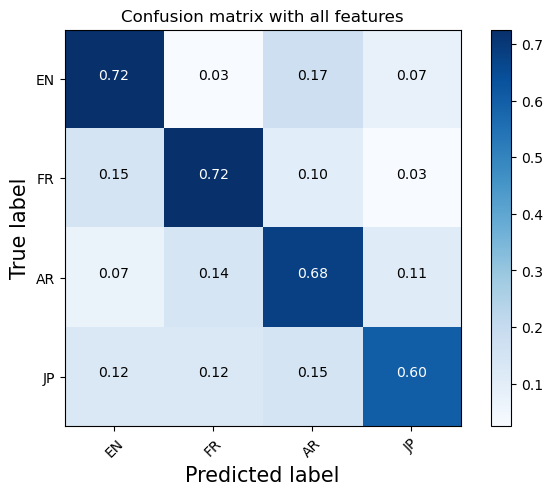

In [36]:
# Create a Random Forest classifier object
classifier = RandomForestClassifier(max_depth=9)

# Train the classifier
classifier.fit(X_train, y_train)

#Make predictions
y_pred_class = classifier.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
# = roc_auc_score(y_test, y_pred_prob)
#print("ROC_AUC_Score: ", roc_auc)

# n_estimators

In [37]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_test) for tree in classifier.estimators_]) # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds.shape, preds[:,0], np.mean(preds[:,0]), y_test[0]

((100, 148),
 array([2., 0., 1., 0., 1., 0., 0., 1., 0., 3., 2., 0., 2., 2., 0., 1., 0.,
        1., 1., 2., 2., 2., 1., 1., 1., 2., 1., 1., 0., 1., 1., 3., 2., 3.,
        3., 0., 1., 1., 1., 3., 1., 2., 2., 1., 1., 2., 2., 1., 1., 2., 1.,
        1., 0., 0., 0., 3., 3., 2., 1., 2., 3., 1., 1., 3., 0., 1., 0., 1.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 3., 1., 2., 1., 2., 1., 2., 3.,
        2., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.]),
 1.19,
 1)

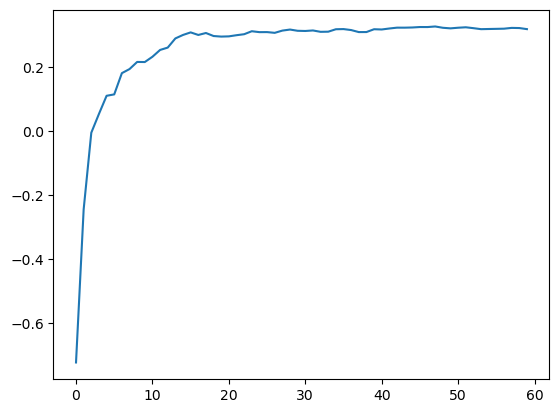

In [38]:
plt.plot([
    metrics.r2_score(y_test, np.mean(preds[:num_trees], axis = 0)) 
    for num_trees in range(1, 61)
])

Accuracy:  0.581081081081081


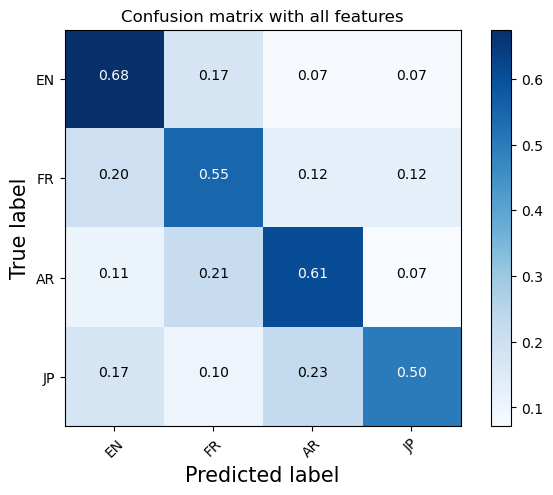

In [39]:
# Create a Random Forest classifier object
classifier = RandomForestClassifier(n_estimators=20, max_depth=8)

# Train the classifier
classifier.fit(X_train, y_train)

#Make predictions
y_pred_class = classifier.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
# = roc_auc_score(y_test, y_pred_prob)
#print("ROC_AUC_Score: ", roc_auc)

# Final model

In [40]:
X_train

[[-310.8645,
  75.35624,
  -36.131123,
  -24.358885,
  -41.369907,
  -18.476292,
  9.404835,
  12.60756,
  -13.367997,
  11.142961,
  4.21523,
  2.6318753,
  -0.06537817,
  22.39306,
  -7.3038154,
  4.9740686,
  -4.6652617,
  10.28968,
  -7.8345976,
  -5.934568,
  10169.09,
  1298.4164,
  631.3558,
  702.8438,
  391.2146,
  245.53572,
  165.53355,
  78.63838,
  136.31277,
  70.70082,
  58.63886,
  63.49769,
  29.229853,
  43.046387,
  47.470734,
  45.04442,
  50.887337,
  48.967304,
  63.193195,
  60.680252],
 [-416.37,
  75.285,
  43.077087,
  21.54858,
  18.632364,
  16.838238,
  -3.2191267,
  1.2174643,
  -5.007253,
  -2.7513454,
  -18.784117,
  -12.536185,
  -14.436864,
  -15.160319,
  -24.60285,
  -8.955956,
  -25.197191,
  -14.262979,
  -18.354376,
  -14.959428,
  15885.686,
  1404.2136,
  778.2014,
  468.42154,
  747.7608,
  197.15446,
  233.47292,
  142.25998,
  101.88093,
  69.1195,
  64.55539,
  49.70909,
  68.8502,
  45.992325,
  52.341175,
  111.56559,
  51.94548,
  143.726

In [41]:
y_train

[0,
 3,
 1,
 2,
 0,
 0,
 3,
 1,
 2,
 3,
 0,
 0,
 1,
 1,
 3,
 2,
 3,
 3,
 3,
 0,
 1,
 3,
 3,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 1,
 1,
 2,
 3,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 3,
 3,
 0,
 0,
 2,
 2,
 3,
 3,
 0,
 0,
 2,
 1,
 3,
 3,
 3,
 2,
 1,
 1,
 3,
 1,
 0,
 0,
 3,
 0,
 2,
 0,
 2,
 2,
 0,
 3,
 3,
 2,
 2,
 3,
 1,
 3,
 3,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 3,
 3,
 3,
 0,
 1,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 0,
 2,
 0,
 3,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 3,
 0,
 2,
 2,
 1,
 0,
 3,
 1,
 3,
 2,
 3,
 3,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 3,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 3,
 0,
 1,
 0,
 0,
 2,
 0,
 3,
 1,
 1,
 2,
 0,
 3,
 3,
 2,
 0,
 0,
 3,
 0,
 1,
 2,
 1,
 3,
 2,
 3,
 2,
 0,
 0,
 1,
 2,
 3,
 3,
 0,
 1,
 1,
 0,
 3,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 3,
 1,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 3,
 2,
 3,
 1,
 0,
 1,
 3,
 1,
 3,
 3,
 0,


Accuracy:  0.6081081081081081


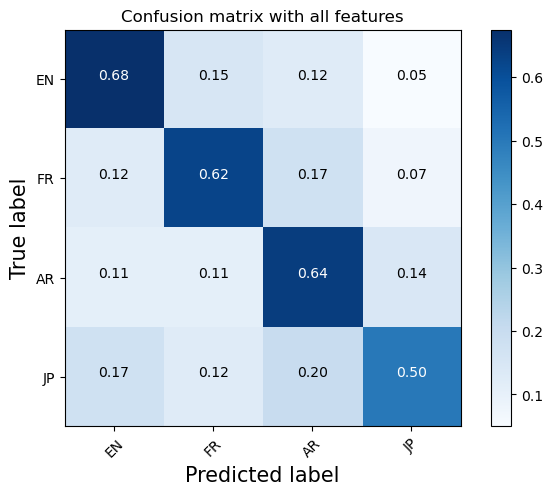

In [42]:
# Create a Random Forest classifier object
clf = RandomForestClassifier(n_estimators=20, max_depth=8)

# Train the classifier
clf.fit(X_train, y_train)

#Make predictions
y_pred_class = clf.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')

# # calculate AUC
# y_pred_prob = clf.predict_proba(X_test)[:, 1]
# # = roc_auc_score(y_test, y_pred_prob)
# #print("ROC_AUC_Score: ", roc_auc)

# CatBoost

In [43]:
from catboost import CatBoostClassifier

0:	learn: 1.3545675	total: 382ms	remaining: 37.8s
1:	learn: 1.3310633	total: 576ms	remaining: 28.2s
2:	learn: 1.3070953	total: 774ms	remaining: 25s
3:	learn: 1.2838564	total: 973ms	remaining: 23.4s
4:	learn: 1.2609378	total: 1.17s	remaining: 22.2s
5:	learn: 1.2351633	total: 1.34s	remaining: 21s
6:	learn: 1.2126844	total: 1.53s	remaining: 20.3s
7:	learn: 1.1882463	total: 1.71s	remaining: 19.7s
8:	learn: 1.1697743	total: 1.91s	remaining: 19.3s
9:	learn: 1.1505781	total: 2.1s	remaining: 18.9s
10:	learn: 1.1335646	total: 2.28s	remaining: 18.5s
11:	learn: 1.1129043	total: 2.46s	remaining: 18.1s
12:	learn: 1.0984837	total: 2.64s	remaining: 17.7s
13:	learn: 1.0819244	total: 2.82s	remaining: 17.3s
14:	learn: 1.0637080	total: 2.99s	remaining: 17s
15:	learn: 1.0504454	total: 3.17s	remaining: 16.6s
16:	learn: 1.0313375	total: 3.35s	remaining: 16.3s
17:	learn: 1.0123988	total: 3.52s	remaining: 16s
18:	learn: 0.9975816	total: 3.7s	remaining: 15.8s
19:	learn: 0.9811341	total: 3.88s	remaining: 15.5s


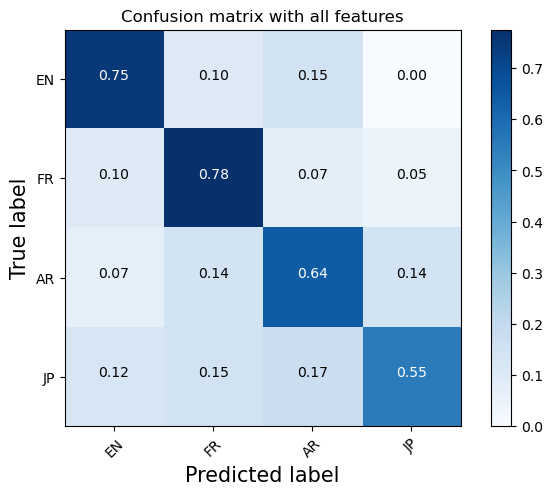

In [44]:
# Create a Random Forest classifier object
cbm = CatBoostClassifier(iterations=100, depth=8, learning_rate=0.1, loss_function='MultiClass')

# Train the classifier
cbm.fit(X_train, y_train)

#Make predictions
y_pred_class = cbm.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')


In [47]:
# Set up data as Pool object
train_data = Pool(X_train, y_train)

In [48]:
# Set up CatBoostClassifier with default hyperparameters
clf = CatBoostClassifier()

# Define hyperparameters to tune
params = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.5, 1, 1.5]
}

# HP TUNING : Iterations

0:	learn: 1.3373649	total: 186ms	remaining: 18.5s
1:	learn: 1.2946063	total: 365ms	remaining: 17.9s
2:	learn: 1.2466094	total: 530ms	remaining: 17.1s
3:	learn: 1.2113249	total: 701ms	remaining: 16.8s
4:	learn: 1.1664352	total: 872ms	remaining: 16.6s
5:	learn: 1.1309013	total: 1.04s	remaining: 16.3s
6:	learn: 1.0964671	total: 1.21s	remaining: 16s
7:	learn: 1.0615845	total: 1.38s	remaining: 15.8s
8:	learn: 1.0300116	total: 1.54s	remaining: 15.6s
9:	learn: 1.0013644	total: 1.72s	remaining: 15.4s
10:	learn: 0.9760084	total: 1.89s	remaining: 15.3s
11:	learn: 0.9524682	total: 2.06s	remaining: 15.1s
12:	learn: 0.9309862	total: 2.23s	remaining: 14.9s
13:	learn: 0.9022049	total: 2.4s	remaining: 14.8s
14:	learn: 0.8775762	total: 2.58s	remaining: 14.6s
15:	learn: 0.8625842	total: 2.75s	remaining: 14.4s
16:	learn: 0.8441349	total: 2.91s	remaining: 14.2s
17:	learn: 0.8193137	total: 3.09s	remaining: 14.1s
18:	learn: 0.7939634	total: 3.26s	remaining: 13.9s
19:	learn: 0.7719653	total: 3.43s	remaining:

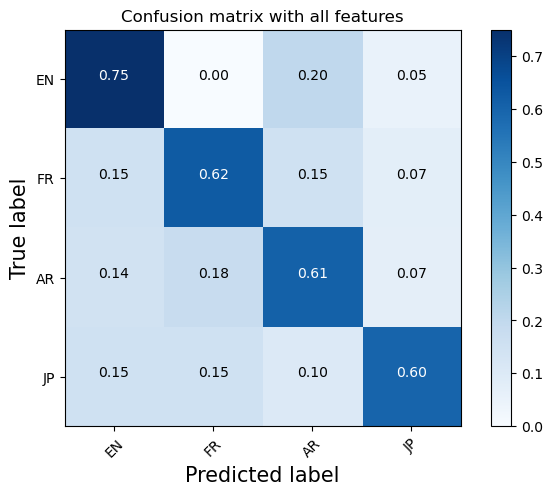

In [49]:
# Create a Random Forest classifier object
cbm = CatBoostClassifier(iterations=100, depth=8, learning_rate=0.1,l2_leaf_reg=1, bagging_temperature=0.5,  loss_function='MultiClass')

# Train the classifier
cbm.fit(X_train, y_train)

#Make predictions
y_pred_class = cbm.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')


0:	learn: 1.3281633	total: 77.8ms	remaining: 15.5s
1:	learn: 1.2856861	total: 152ms	remaining: 15.1s
2:	learn: 1.2386631	total: 228ms	remaining: 15s
3:	learn: 1.1979948	total: 302ms	remaining: 14.8s
4:	learn: 1.1588291	total: 376ms	remaining: 14.6s
5:	learn: 1.1305820	total: 448ms	remaining: 14.5s
6:	learn: 1.0855914	total: 522ms	remaining: 14.4s
7:	learn: 1.0442452	total: 596ms	remaining: 14.3s
8:	learn: 1.0105490	total: 671ms	remaining: 14.2s
9:	learn: 0.9820344	total: 745ms	remaining: 14.1s
10:	learn: 0.9526374	total: 819ms	remaining: 14.1s
11:	learn: 0.9221114	total: 892ms	remaining: 14s
12:	learn: 0.8947210	total: 963ms	remaining: 13.9s
13:	learn: 0.8670852	total: 1.04s	remaining: 13.8s
14:	learn: 0.8446426	total: 1.11s	remaining: 13.7s
15:	learn: 0.8247749	total: 1.18s	remaining: 13.6s
16:	learn: 0.7993866	total: 1.26s	remaining: 13.6s
17:	learn: 0.7801764	total: 1.33s	remaining: 13.5s
18:	learn: 0.7592676	total: 1.41s	remaining: 13.4s
19:	learn: 0.7415259	total: 1.48s	remaining:

163:	learn: 0.0767247	total: 11.9s	remaining: 2.61s
164:	learn: 0.0760397	total: 12s	remaining: 2.54s
165:	learn: 0.0753097	total: 12s	remaining: 2.46s
166:	learn: 0.0746164	total: 12.1s	remaining: 2.39s
167:	learn: 0.0739606	total: 12.2s	remaining: 2.32s
168:	learn: 0.0733997	total: 12.2s	remaining: 2.25s
169:	learn: 0.0728663	total: 12.3s	remaining: 2.17s
170:	learn: 0.0722760	total: 12.4s	remaining: 2.1s
171:	learn: 0.0716628	total: 12.5s	remaining: 2.03s
172:	learn: 0.0711108	total: 12.5s	remaining: 1.95s
173:	learn: 0.0704125	total: 12.6s	remaining: 1.88s
174:	learn: 0.0698397	total: 12.7s	remaining: 1.81s
175:	learn: 0.0692386	total: 12.7s	remaining: 1.73s
176:	learn: 0.0687067	total: 12.8s	remaining: 1.66s
177:	learn: 0.0683188	total: 12.9s	remaining: 1.59s
178:	learn: 0.0676989	total: 12.9s	remaining: 1.52s
179:	learn: 0.0672572	total: 13s	remaining: 1.44s
180:	learn: 0.0669483	total: 13.1s	remaining: 1.37s
181:	learn: 0.0664213	total: 13.1s	remaining: 1.3s
182:	learn: 0.065927

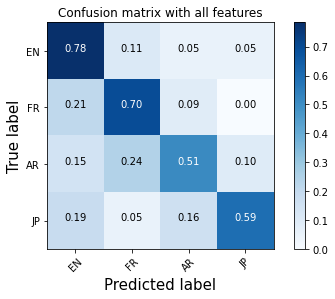

In [106]:
# Create a Random Forest classifier object
cbm = CatBoostClassifier(iterations=200, depth=8, learning_rate=0.1,l2_leaf_reg=1, bagging_temperature=0.5,  loss_function='MultiClass')

# Train the classifier
cbm.fit(X_train, y_train)

#Make predictions
y_pred_class = cbm.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')


0:	learn: 1.2488057	total: 197ms	remaining: 39.2s
1:	learn: 1.1420534	total: 391ms	remaining: 38.7s
2:	learn: 1.0542539	total: 575ms	remaining: 37.8s
3:	learn: 0.9753299	total: 762ms	remaining: 37.3s
4:	learn: 0.8849993	total: 945ms	remaining: 36.8s
5:	learn: 0.8193981	total: 1.13s	remaining: 36.4s
6:	learn: 0.7450178	total: 1.3s	remaining: 36s
7:	learn: 0.6811609	total: 1.5s	remaining: 36.1s
8:	learn: 0.6321844	total: 1.7s	remaining: 36.1s
9:	learn: 0.5875456	total: 1.89s	remaining: 36s
10:	learn: 0.5591951	total: 2.07s	remaining: 35.5s
11:	learn: 0.5256932	total: 2.25s	remaining: 35.3s
12:	learn: 0.4990007	total: 2.44s	remaining: 35.1s
13:	learn: 0.4625130	total: 2.63s	remaining: 34.9s
14:	learn: 0.4336346	total: 2.83s	remaining: 34.9s
15:	learn: 0.4184321	total: 3.01s	remaining: 34.6s
16:	learn: 0.3964345	total: 3.21s	remaining: 34.6s
17:	learn: 0.3698400	total: 3.41s	remaining: 34.4s
18:	learn: 0.3475332	total: 3.59s	remaining: 34.2s
19:	learn: 0.3267967	total: 3.8s	remaining: 34.2

162:	learn: 0.0211191	total: 30.6s	remaining: 6.96s
163:	learn: 0.0209743	total: 30.8s	remaining: 6.76s
164:	learn: 0.0208413	total: 31s	remaining: 6.58s
165:	learn: 0.0207223	total: 31.2s	remaining: 6.39s
166:	learn: 0.0206066	total: 31.4s	remaining: 6.2s
167:	learn: 0.0205196	total: 31.6s	remaining: 6.01s
168:	learn: 0.0203614	total: 31.7s	remaining: 5.82s
169:	learn: 0.0202815	total: 31.9s	remaining: 5.63s
170:	learn: 0.0201530	total: 32.1s	remaining: 5.45s
171:	learn: 0.0200433	total: 32.3s	remaining: 5.26s
172:	learn: 0.0199569	total: 32.5s	remaining: 5.07s
173:	learn: 0.0198772	total: 32.7s	remaining: 4.88s
174:	learn: 0.0197699	total: 32.9s	remaining: 4.7s
175:	learn: 0.0196809	total: 33.1s	remaining: 4.51s
176:	learn: 0.0195500	total: 33.2s	remaining: 4.32s
177:	learn: 0.0194515	total: 33.5s	remaining: 4.13s
178:	learn: 0.0193231	total: 33.7s	remaining: 3.95s
179:	learn: 0.0192723	total: 33.9s	remaining: 3.76s
180:	learn: 0.0191631	total: 34.1s	remaining: 3.58s
181:	learn: 0.01

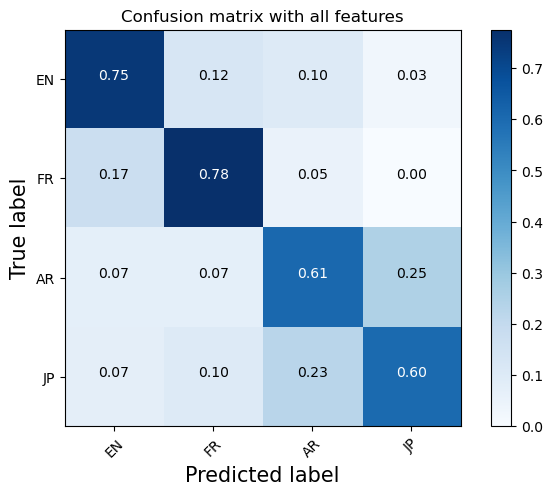

In [50]:
# Create a Random Forest classifier object
cbm = CatBoostClassifier(iterations=200, depth=8, learning_rate=0.3,l2_leaf_reg=1, bagging_temperature=0.5,  loss_function='MultiClass')

# Train the classifier
cbm.fit(X_train, y_train)

#Make predictions
y_pred_class = cbm.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')


0:	learn: 1.2234415	total: 78.7ms	remaining: 15.7s
1:	learn: 1.1191876	total: 145ms	remaining: 14.4s
2:	learn: 0.9890065	total: 212ms	remaining: 13.9s
3:	learn: 0.9008139	total: 282ms	remaining: 13.8s
4:	learn: 0.8170949	total: 350ms	remaining: 13.6s
5:	learn: 0.7658809	total: 415ms	remaining: 13.4s
6:	learn: 0.6991854	total: 483ms	remaining: 13.3s
7:	learn: 0.6376039	total: 555ms	remaining: 13.3s
8:	learn: 0.5910443	total: 623ms	remaining: 13.2s
9:	learn: 0.5598657	total: 696ms	remaining: 13.2s
10:	learn: 0.5206167	total: 767ms	remaining: 13.2s
11:	learn: 0.4837213	total: 835ms	remaining: 13.1s
12:	learn: 0.4566438	total: 908ms	remaining: 13.1s
13:	learn: 0.4239806	total: 974ms	remaining: 12.9s
14:	learn: 0.4019174	total: 1.04s	remaining: 12.9s
15:	learn: 0.3836503	total: 1.11s	remaining: 12.8s
16:	learn: 0.3595417	total: 1.18s	remaining: 12.7s
17:	learn: 0.3383818	total: 1.25s	remaining: 12.6s
18:	learn: 0.3195195	total: 1.32s	remaining: 12.6s
19:	learn: 0.2999746	total: 1.39s	remain

161:	learn: 0.0242948	total: 11.5s	remaining: 2.7s
162:	learn: 0.0241804	total: 11.6s	remaining: 2.63s
163:	learn: 0.0240549	total: 11.7s	remaining: 2.56s
164:	learn: 0.0239685	total: 11.8s	remaining: 2.49s
165:	learn: 0.0238364	total: 11.8s	remaining: 2.42s
166:	learn: 0.0237446	total: 11.9s	remaining: 2.35s
167:	learn: 0.0236346	total: 12s	remaining: 2.28s
168:	learn: 0.0235467	total: 12.1s	remaining: 2.21s
169:	learn: 0.0234470	total: 12.1s	remaining: 2.14s
170:	learn: 0.0233301	total: 12.2s	remaining: 2.07s
171:	learn: 0.0231941	total: 12.3s	remaining: 2s
172:	learn: 0.0231197	total: 12.3s	remaining: 1.92s
173:	learn: 0.0230478	total: 12.4s	remaining: 1.85s
174:	learn: 0.0229527	total: 12.5s	remaining: 1.78s
175:	learn: 0.0228471	total: 12.5s	remaining: 1.71s
176:	learn: 0.0227571	total: 12.6s	remaining: 1.64s
177:	learn: 0.0226467	total: 12.7s	remaining: 1.57s
178:	learn: 0.0225569	total: 12.7s	remaining: 1.5s
179:	learn: 0.0224442	total: 12.8s	remaining: 1.42s
180:	learn: 0.02242

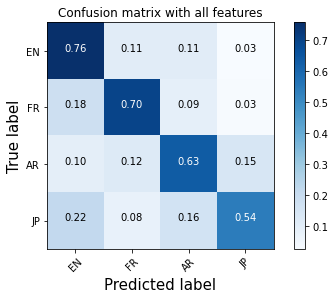

In [130]:
# Create a Random Forest classifier object
cbm = CatBoostClassifier(iterations=200, depth=8, learning_rate=0.3,l2_leaf_reg=1, bagging_temperature=0.5,  loss_function='MultiClass')

# Train the classifier
cbm.fit(X_train, y_train)

#Make predictions
y_pred_class = cbm.predict(X_test)
# print the model's accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)


# plot cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EN','FR','AR','JP'],normalize=True,
                      title='Confusion matrix with all features')


# Output

In [83]:
#set data_dir to the directory of your data files
data_dir= r"C:\Users\Natha\emlyon-dsaib\Python tutorship\Projet\language-identification-lid2\Evaluation_Set\evaluation_set"

# Read file info file to get the list of audio files and their labels
file_list=[]
label_list=[]
with open(data_dir+"\Info.txt", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # The first column contains the file name
        file_list.append(row[0])

lang_dic={'EN':0,'FR':1,'AR':2,'JP':3}
class2lang_dic={0:"EN",1:"FR",2:"AR",3:"JP"}

for test_sample in file_list:
    test_sample_feature=feature_extractor_1 (data_dir+'\\' + test_sample)
    predicted=class2lang_dic[clf.predict([test_sample_feature])[0]]
    print(f'Predicted class: "{predicted}"')
    # save the predicted output in Output_evaluation.txt
    with open(data_dir+"[YourNAME_YourModelName_Version].csv",'a+') as file:
        file.write(f"{test_sample},{predicted}\n")

Predicted class: "JP"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "AR"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "JP"
Predicted class: "AR"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "FR"
Predicted 

Predicted class: "AR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "AR"
Predicted class: "JP"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "JP"
Predicted class: "EN"
Predicted 

Predicted class: "EN"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "EN"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "AR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "AR"
Predicted class: "AR"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "JP"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "FR"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "EN"
Predicted class: "JP"
Predicted class: "EN"
Predicted class: "FR"
Predicted 